
# Mortgage Prepayment Modeling - Final Project 5A

This notebook analyzes mortgage loan data and predicts prepayment behavior (CPR - Conditional Prepayment Rate)
using various models including logistic regression and neural networks. The workflow includes:

- Data preprocessing
- CPR calculation 
- Feature engineering
- Model training and evaluation
- Hyperparameter tuning

---


In [24]:
# Import required libraries
# You may need to install keras_tuner and tensorflow
from imports import *

# Data Loading and Preprocessing
This section loads the dataset and preprocesses the interest rates. The dataset is read from an Excel file, and the interest rates are loaded from a CSV file. The date column is formatted correctly for further analysis.

___

In [25]:
# Load dataset and preprocess interest rates
Dataset = pd.read_excel('Dataset.xlsx')
Rates = pd.read_csv("rates_202203.csv", delimiter=";")

# Clean column names by stripping any leading/trailing spaces
Rates.columns = Rates.columns.str.strip()

# Convert the 'Date' column to datetime format and set it as the index
Rates['Date'] = pd.to_datetime(Rates['Date'], errors='coerce')
Rates.set_index('Date', inplace=True)
Rates.sort_index(inplace=True)

# Conditional Prepayment Rate (CPR) Calculation
This section calculates the Conditional Prepayment Rate (CPR) for each month. The CPR is a measure of mortgage prepayment risk and is derived from the raw dataset.
___

In [33]:
# Define a function to compute the CPR (Conditional Prepayment Rate)
def filtered_ratio(group):
    numerator = group[~group['FLG_OPER'].isin([0, 4, 5])]['VOL_OPER'].sum()
    denominator = group['IM_CAPRES'].sum()
    return numerator / denominator if denominator > 0 else np.nan

# Group the dataset by 'ANNO_MESE_post' and apply the filtered_ratio function
ratios = Dataset.groupby('ANNO_MESE_post').apply(filtered_ratio)

# Map the computed CPR back to each row in the dataset
Dataset['CPR'] = Dataset['ANNO_MESE_post'].map(ratios)

C:\Users\39348\AppData\Local\Temp\ipykernel_22240\1221067033.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratios = Dataset.groupby('ANNO_MESE_post').apply(filtered_ratio)


# Feature Engineering: Market Features
This section constructs market-related features that will be used for modeling.
___

In [27]:
# Feature (a): Volume-weighted average contract rate for fixed-rate mortgages
def weighted_average(group):
    weighted_sum = (group['PC_TAS_ATTU_FI'] * group['IMP_CONTR_FI']).sum()
    total_amount = group['IMP_CONTR_FI'].sum()
    return weighted_sum / total_amount if total_amount > 0 else None

# Compute the volume-weighted average contract rates for each month
monthly_vwa = Dataset.groupby('ANNO_MESE_EROG').apply(weighted_average).reset_index(name='VWA_Contract_Rate')
vwa = pd.Series(monthly_vwa['VWA_Contract_Rate'].iloc[376:543])
vwa.index = Rates.index

# Feature (b): EUR3M rate
euribor_feature = Rates["EUR3M"]
euribor_feature.index = Rates.index

# Feature (c): Average of IRS rates (10Y–30Y)
irs_columns = ["IRS10Y", "IRS15Y", "IRS20Y", "IRS25Y", "IRS30Y"]
irs_avg_feature = Rates[irs_columns].mean(axis=1)
irs_avg_feature.index = Rates.index

# Feature (d): Difference between current IRS average and historical minimum (excluding past 12 months)
irs_diff_feature = []
for i in range(len(Rates)):
    current_date = Rates.index[i]
    cutoff = current_date - pd.DateOffset(months=12)
    past_data = irs_avg_feature[irs_avg_feature.index <= cutoff]
    if not past_data.empty:
        hist_min = past_data.min()
        diff = irs_avg_feature.iloc[i] - hist_min
    else:
        diff = None
    irs_diff_feature.append(diff)

irs_diff_feature = pd.Series(irs_diff_feature, index=Rates.index)

# Combine all market features into a single DataFrame
MKT_features = pd.DataFrame({
    "EUR3M_avg": euribor_feature,
    "IRS_avg": irs_avg_feature,
    "IRS_vs_hist_min": irs_diff_feature,
    "VWA": vwa
})

# Correct the date format in the MKT_features index
date_str = MKT_features.index.astype(str)
corrected_dates = pd.to_datetime(date_str, format='%Y-%d-%m', errors='coerce')
MKT_features.index = corrected_dates

C:\Users\39348\AppData\Local\Temp\ipykernel_22240\2329897074.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_vwa = Dataset.groupby('ANNO_MESE_EROG').apply(weighted_average).reset_index(name='VWA_Contract_Rate')


# Feature Engineering: Contract Features
This section constructs contract-related features such as outstanding amounts, origination dates, and maturity terms.
___

In [28]:
# Create a DataFrame for contract-related features
CONT_features = pd.DataFrame({
    "Current_Outstanding_Amount": Dataset['IM_CAPRES'],
    "Initial_Outstanding_Amount": Dataset['IMP_CONTR_FI'],
    "Time_from_contract_orgination": Dataset['TOC'],
    "Contract_full_rate": Dataset['PC_TAS_ATTU_FI'],
    "Contract_spread_rate": Dataset['PC_SPREAD_FI'],
    "orginal_maturity": Dataset['ORIG_MAT'],
    "month_of_dis_loan": Dataset['ANNO_MESE_EROG'],
    "ref_date": Dataset["ANNO_MESE_post"],
    "volume": Dataset['VOL_OPER'],
    "CPR": Dataset['CPR'],
    "flags": Dataset['FLG_OPER']
})

# Combining Features into a Feature Matrix
This section merges the market and contract features into a single feature matrix for modeling. It also adds a seasonality feature based on the loan disbursement month.
___

In [29]:
# Merge contract and market features
Featurematrix = pd.merge(CONT_features, MKT_features, left_on="ref_date", right_on=MKT_features.index, how='left')

# Convert date columns to datetime format
Featurematrix['month_of_dis_loan'] = pd.to_datetime(Featurematrix['month_of_dis_loan'])

# Add a seasonality feature (1 if the month is August, else 0)
Featurematrix['seasonality'] = Featurematrix['month_of_dis_loan'].dt.month == 8
Featurematrix['seasonality'] = Featurematrix['seasonality'].astype(int)

# Drop unnecessary columns
Featurematrix.drop(columns=['volume', "month_of_dis_loan", 'ref_date', 'Contract_spread_rate'], inplace=True)

# Display the final feature matrix
Featurematrix

,Current_Outstanding_Amount,Initial_Outstanding_Amount,Time_from_contract_orgination,Contract_full_rate,orginal_maturity,CPR,flags,EUR3M_avg,IRS_avg,IRS_vs_hist_min,VWA,seasonality
0,0,13,664,5.0,910,0.006913,0,0.67,3.800,0.166,4.501024,1
1,0,3,631,8.0,660,0.014403,0,0.71,3.178,-0.456,3.940549,0
2,0,5,628,5.0,836,0.000887,0,0.32,2.098,-0.760,4.329806,0
3,0,5,624,5.0,833,0.001160,0,0.64,1.992,-0.866,4.569081,0
4,0,6,620,5.0,822,0.002969,0,0.83,2.496,-0.362,5.227797,0
...,...,...,...,...,...,...,...,...,...,...,...,...
431817,362,362,0,1.4,361,0.002909,0,-0.51,1.006,1.080,1.232297,0
431818,135,135,0,1.2,361,0.002909,0,-0.51,1.006,1.080,1.232297,0
431819,272,272,0,1.2,217,0.002909,0,-0.51,1.006,1.080,1.232297,0
431820,287,287,0,1.3,361,0.002909,0,-0.51,1.006,1.080,1.232297,0


# Neural Network vs Logistic Regression with temporal split

This section trains a neural network with volume-weighted loss to predict CPR, tunes it with Hyperband, compares results with a logistic regression, and visualizes predictions and residuals over time. The train,test split used is the temporal one, which in practice is used in financial applications


---

Reloading Tuner from keras_tuner_dir\cpr_nn_opt_backup\tuner0.json


c:\Users\39348\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\39348\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


=== Best Hyperparameters ===
units_1: 96
n_layers: 3
units_2: 32
lr: 0.01
units_3: 32
units_4: 64
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0068
13495/13495 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


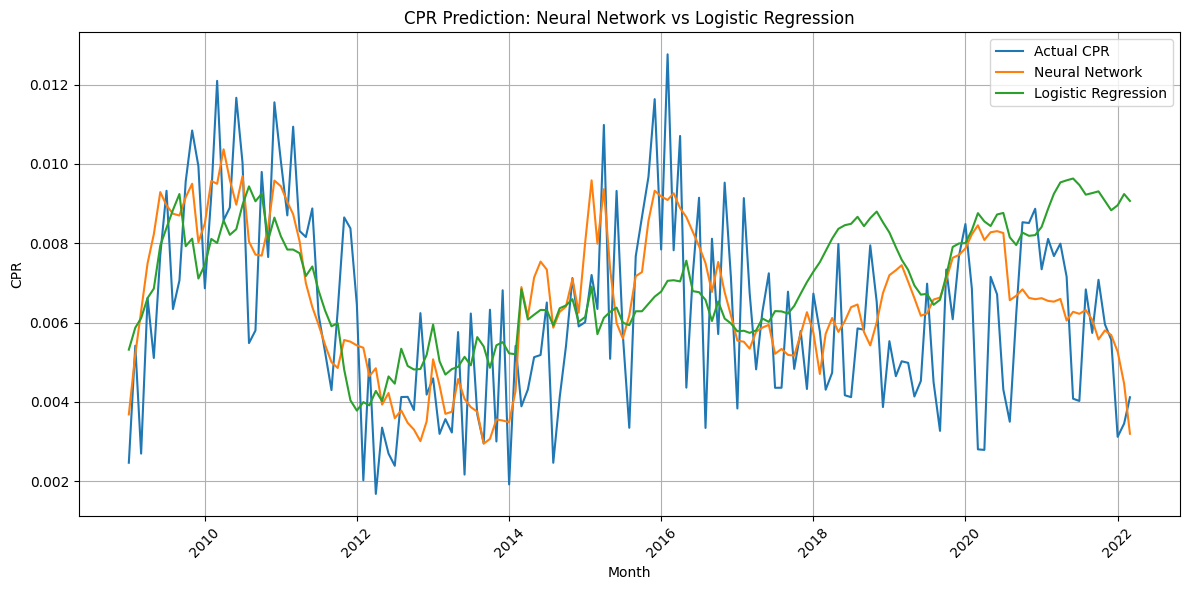

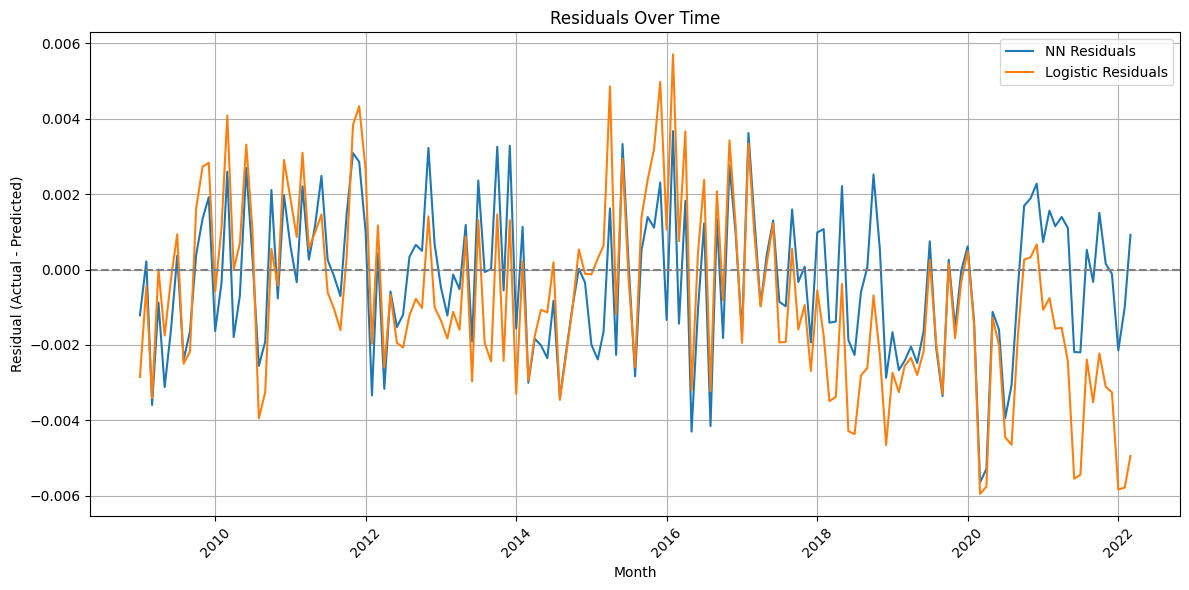

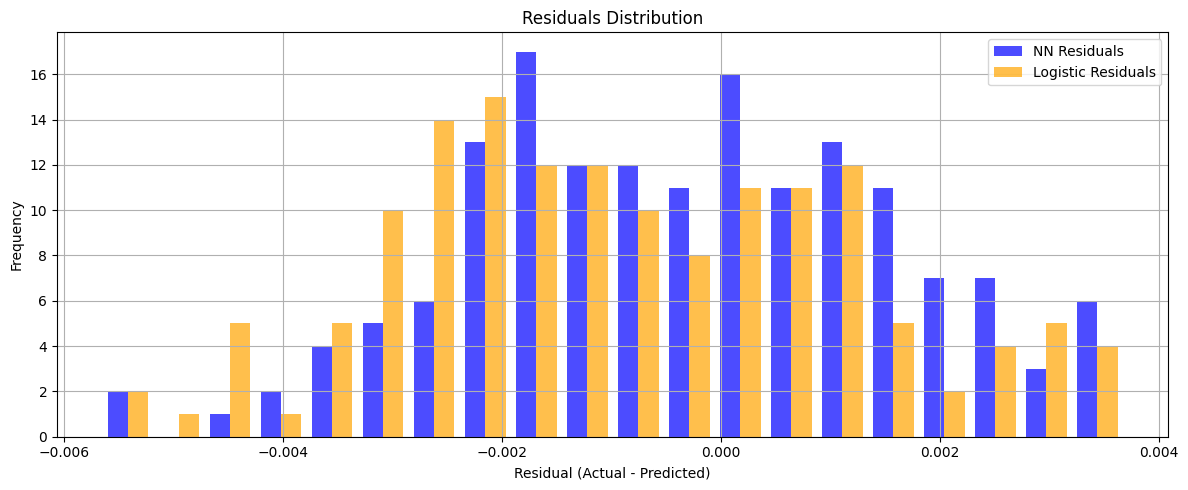

In [30]:
# Note: Running this code from the start may take around 20-25 minutes, as it performs 
# a search over multiple hyperparameter combinations to find the optimal set for best performance.
# For this reason the code now recalls directly the optimal model tuned before 
# (to run the optimization again from start it is enough to change the project name in the Hyperband function).


# --- Data Preparation ---
df = Featurematrix.copy()
df['Month'] = pd.to_datetime(Dataset['ANNO_MESE_post'], format='%d/%m/%Y').dt.to_period('M')
X_num = df.drop(columns=['Month', 'flags', 'CPR'])
y_bin = df['flags'].isin([1, 2, 3]).astype(int).values.reshape(-1, 1)
V_out = df['Current_Outstanding_Amount'].values.reshape(-1, 1)

# Temporal Split
n = len(df)
train_end, val_end = int(n * 0.8), int(n * 0.9)
X_train, y_train, V_train = X_num.iloc[:train_end], y_bin[:train_end], V_out[:train_end]
X_val, y_val, V_val = X_num.iloc[train_end:val_end], y_bin[train_end:val_end], V_out[train_end:val_end]
X_test, y_test, V_test = X_num.iloc[val_end:], y_bin[val_end:], V_out[val_end:]

# Imputation and Scaling
means = X_train.mean()
X_train, X_val, X_test = X_train.fillna(means), X_val.fillna(means), X_test.fillna(means)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)
X_train_s = X_train_s.astype(np.float32)
X_val_s = X_val_s.astype(np.float32)
X_test_s = X_test_s.astype(np.float32)

# --- Custom Loss Function ---
class VolumeWeightedBCE(tf.keras.losses.Loss):
    def __init__(self, total_outstanding):
        super().__init__()
        self.total_out = tf.cast(total_outstanding, tf.float32)
    def call(self, y_true, y_pred):
        cpr = y_true[:, 0:1]
        v = y_true[:, 1:2]
        w = v / self.total_out
        bce = binary_crossentropy(cpr, y_pred)
        return tf.reduce_mean(bce * w)

# --- Model Builder for Hyperparameter Tuning ---
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', 32, 128, step=32), activation='relu', kernel_initializer=HeNormal(),
                    input_shape=(X_train_s.shape[1],)))

    n_layers = hp.Int("n_layers", 1, 3)
    units = [hp.Int(f'units_{i+2}', 32, 128, step=32) for i in range(n_layers)]
    
    for u in units:
        model.add(Dense(u, activation='relu', kernel_initializer=HeNormal()))
    
    model.add(Dense(1, activation='sigmoid'))

    lr = hp.Choice('lr', [1e-2, 1e-3, 5e-4])
    model.compile(optimizer=Adam(learning_rate=lr), loss=VolumeWeightedBCE(V_train.sum()))
    return model


# --- Hyperparameter Tuning ---
tuner = kt.Hyperband(build_model, objective='val_loss', max_epochs=30, factor=3,
                     directory='keras_tuner_dir', project_name='cpr_nn_opt_backup')


stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
y_train_pack = np.hstack([y_train, V_train]).astype(np.float32)
y_val_pack = np.hstack([y_val, V_val]).astype(np.float32)

tuner.search(X_train_s, y_train_pack, validation_data=(X_val_s, y_val_pack),
             epochs=30, batch_size=1000, callbacks=[stop], verbose=1)

# --- Final Best Model ---
best_model = tuner.get_best_models(1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("=== Best Hyperparameters ===")
[print(f"{k}: {v}") for k, v in best_hps.values.items()]


# --- Predictions ---
X_all = X_num.fillna(means)
X_all_s = scaler.transform(X_all)
pred_all_nn = best_model.predict(X_all_s).flatten()

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_s, y_train.ravel())
pred_all_log = log_reg.predict_proba(X_all_s)[:, 1]

# --- Monthly Aggregation ---
full_results = pd.DataFrame({
    'Month': df['Month'].astype(str),
    'Actual_CPR': y_bin.flatten(),
    'Pred_NN': pred_all_nn,
    'Pred_LogReg': pred_all_log
})

monthly_avg = full_results.groupby('Month', as_index=False).mean()

# --- Plotting ---
x = pd.to_datetime(monthly_avg['Month'])
y_act = monthly_avg['Actual_CPR']
y_nn = monthly_avg['Pred_NN']
y_log = monthly_avg['Pred_LogReg']
x = np.array(x)
y_act = np.array(y_act)
y_nn = np.array(y_nn)
y_log = np.array(y_log)


plt.figure(figsize=(12, 6))
plt.plot(x, y_act, label='Actual CPR')
plt.plot(x, y_nn, label='Neural Network')
plt.plot(x, y_log, label='Logistic Regression')
plt.xlabel("Month")
plt.ylabel("CPR")
plt.title("CPR Prediction: Neural Network vs Logistic Regression")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residuals
resid_nn = y_act - y_nn
resid_log = y_act - y_log

plt.figure(figsize=(12, 6))
plt.plot(x, resid_nn, label='NN Residuals')
plt.plot(x, resid_log, label='Logistic Residuals')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Month")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histogram
bins = 20
counts_nn, bin_edges = np.histogram(resid_nn, bins=bins)
counts_log, _ = np.histogram(resid_log, bins=bin_edges)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
width = (bin_edges[1] - bin_edges[0]) / 2.5

plt.figure(figsize=(12, 5))
plt.bar(bin_centers - width / 2, counts_nn, width=width, alpha=0.7, label='NN Residuals', color='blue')
plt.bar(bin_centers + width / 2, counts_log, width=width, alpha=0.7, label='Logistic Residuals', color='orange')
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()